In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nelpy as nel
from scipy.io import savemat, loadmat
from scipy import interpolate
from scipy.signal import savgol_filter

/home/kemerelab/nelpy/nelpy/plotting/decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


# Bin behavior data

In [3]:
d = np.load('/home/kemerelab/Downloads/mazesEEG/RatS-Day5TwoNovel-2020-12-04_07-55-09.paradigm.npy',allow_pickle=True)
period_names = d.item(0)['epochs']['label'].values
period = np.vstack((d.item(0)['epochs']['start'].values,d.item(0)['epochs']['stop'].values))
period_bounds = nel.EpochArray(period.T)
period_names, period_bounds.data

(array(['pre', 'maze1', 'post1', 'maze2', 'post2'], dtype=object),
 array([[    0, 11066],
        [11070, 13970],
        [13972, 20754],
        [20756, 24004],
        [24006, 42305]]))

In [4]:
# Define maze ID
maze_id = 3
period_names[maze_id]

'maze2'

In [5]:
pos_lin = nel.load_pkl(period_names[maze_id]+'_raw_pos.nel')
mazetime = pos_lin.abscissa_vals
pos_1d = pos_lin.data.squeeze()
mazetime.shape, pos_1d.shape

((194880,), (194880,))

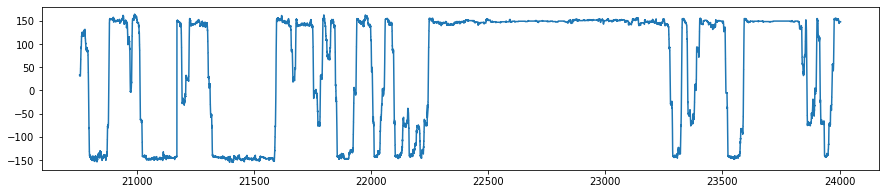

In [6]:
plt.figure(figsize=(15,3))
plt.plot(mazetime,pos_1d)

## speed sanity check

In [7]:
mazetime[0],mazetime[-1],period_bounds[maze_id].data

(20756.008176978234, 24003.992789878394, array([[20756, 24004]]))

In [8]:
tbin = 0.5 # speed is computed in 500s time bin
time = np.arange(period_bounds[maze_id].data[0,0]+10,period_bounds[maze_id].data[0,1]-9,tbin) # time samples in 500ms interval
time.shape, time[0],time[-1]

((6458,), 20766.0, 23994.5)

In [9]:
f = interpolate.interp1d(mazetime,pos_1d)
pos_linear = f(time)
speed_linear = np.abs(np.gradient(pos_linear))/tbin
speed_linear.shape, pos_linear.shape

((6458,), (6458,))

In [11]:
position = np.load('/home/kemerelab/Downloads/mazesEEG/RatS-Day5TwoNovel-2020-12-04_07-55-09_position.npy',allow_pickle=True)
timestamps = position.item(0)['time']
x1 = position.item(0)['x']
y1 = position.item(0)['y']
timestamps.shape, x1.shape, y1.shape

((2538347,), (2538347,), (2538347,))

In [12]:
f = interpolate.interp1d(timestamps,np.vstack((x1, y1)))
pos_origin = f(time)
pos_origin.shape

(2, 6458)

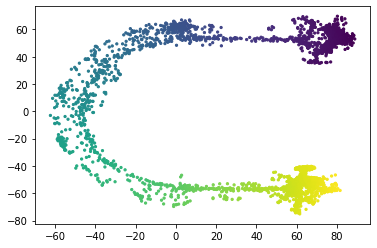

In [13]:
plt.scatter(pos_origin[0,:],pos_origin[1,:],s=5,c=pos_linear)

In [24]:
# dic={'time_all': time, 'pos_linear': pos_linear, 'pos_origin': pos_origin}
# dic

{'time_all': array([11080. , 11080.5, 11081. , ..., 13959.5, 13960. , 13960.5]),
 'pos_linear': array([160.73936621, 160.73936621, 160.73936621, ...,  21.2261246 ,
         19.74302485,  19.73325621]),
 'pos_origin': array([[-58.74814349, -60.19980849, -57.2301462 , ...,  83.58932321,
          84.92365669,  84.78598642],
        [-58.40559676, -53.94984348, -60.53147475, ..., -64.64847402,
         -68.97539318, -73.23846349]])}

In [25]:
# savemat('maze1_pos_500ms.mat',dic)

In [14]:
speed_linear_gra = np.diff(speed_linear)

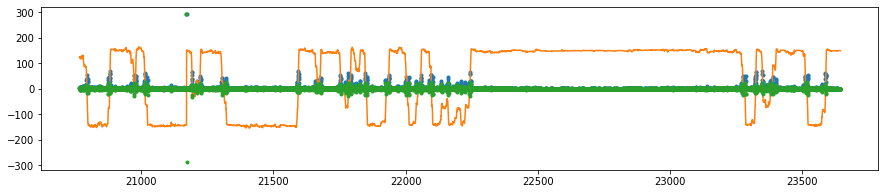

In [15]:
plt.figure(figsize=(15,3))
rangeidx = [0,5761]
# rangeidx = [12600, 12750]
plt.plot(time[rangeidx[0]:rangeidx[1]],speed_linear[rangeidx[0]:rangeidx[1]],'.')
plt.plot(time[rangeidx[0]:rangeidx[1]],pos_linear[rangeidx[0]:rangeidx[1]])
plt.plot(time[rangeidx[0]:rangeidx[1]],speed_linear_gra[rangeidx[0]:rangeidx[1]],'.')

Text(0.5, 1.0, 'histogram of speed')

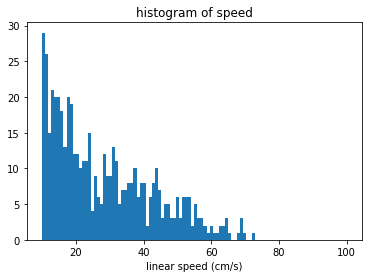

In [16]:
plt.hist(speed_linear,bins=100,range=(10,100))
plt.xlabel('linear speed (cm/s)')
plt.title('histogram of speed')

In [17]:
speed_linear.shape, pos_linear.shape

((6458,), (6458,))

(800.0, 1000.0)

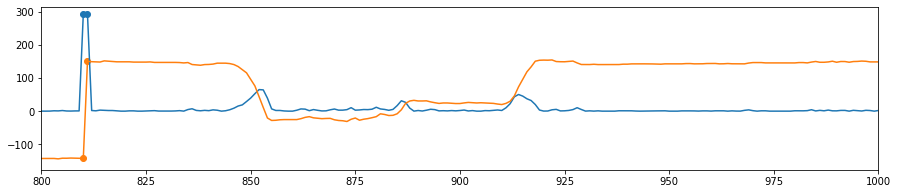

In [22]:
# # exclude speed outliers before smoothing speed
# f = interpolate.interp1d(time[np.where(speed_linear<80)],speed_linear[np.where(speed_linear<80)])
# speed_linear_sm = f(time)
# # exclude position with speed outliers
# f = interpolate.interp1d(time[np.where(speed_linear<80)],pos_linear[np.where(speed_linear<80)])
# pos_linear_sm = f(time)

plt.figure(figsize=(15,3))
plt.plot(speed_linear)
plt.scatter(np.where(speed_linear>80),speed_linear[speed_linear>80])
plt.plot(pos_linear)
plt.scatter(np.where(speed_linear>80),pos_linear[speed_linear>80])
plt.xlim([800,1000])

In [56]:
np.where(speed_linear>400)

(array([], dtype=int64),)

In [21]:
pos_linear[810:813]

array([-142.45703239,  150.37498873,  149.08799413])

In [76]:
filter_win=21
speed_ol = 80 # speed outlier

In [77]:
bp = np.insert(np.where(speed_linear>speed_ol),0,0)
bp = np.append(bp,np.size(speed_linear))
bp

array([   0,  810,  811, 6458])

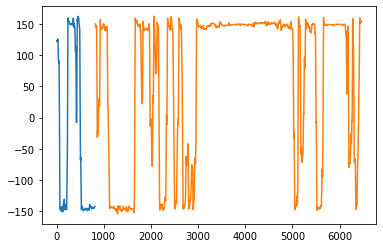

In [87]:
speed_r = []
time_r = []
pos_r = []
for i in range(bp.size-1):
    pos_tmp = pos_linear[bp[i]:bp[i+1]]
    if pos_tmp.size>filter_win:
        pos_tmp_sm = savgol_filter(pos_tmp, filter_win, 2)
        time_r.append(time[bp[i]:bp[i+1]])
        pos_r.append(pos_tmp_sm)
        speed_r.append(np.abs(np.gradient(pos_tmp_sm))/tbin)
        plt.plot(np.arange(bp[i],bp[i+1]),pos_tmp_sm)
speed_r=np.concatenate(speed_r)
time_r=np.concatenate(time_r)
pos_r = np.concatenate(pos_r)

In [79]:
time_r.shape, speed_r.shape

((6457,), (6457,))

In [88]:
f = interpolate.interp1d(time_r,speed_r)
speed = f(time)
f = interpolate.interp1d(time_r,pos_r)
pos_linear_for_spd = f(time)

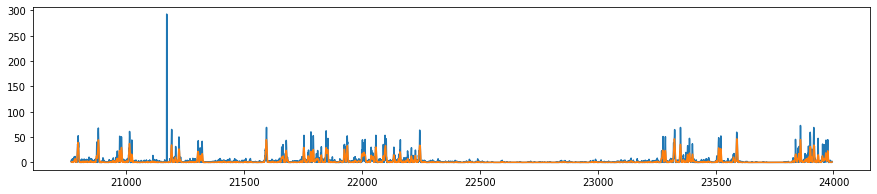

In [83]:
plt.figure(figsize=(15,3))
plt.plot(time,speed_linear)
plt.plot(time_r,speed_r)

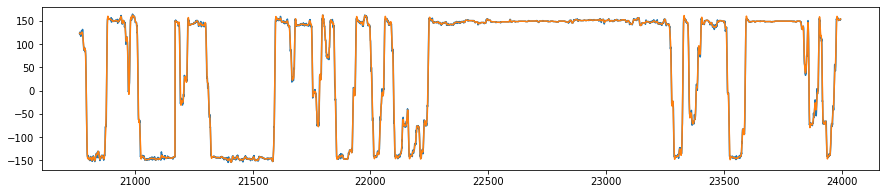

In [90]:
plt.figure(figsize=(15,3))
plt.plot(time,pos_linear)
plt.plot(time,pos_linear_for_spd)

## Get run epochs

In [84]:
v1=3
v2=5
plot=False
display_range=[21500,22550]

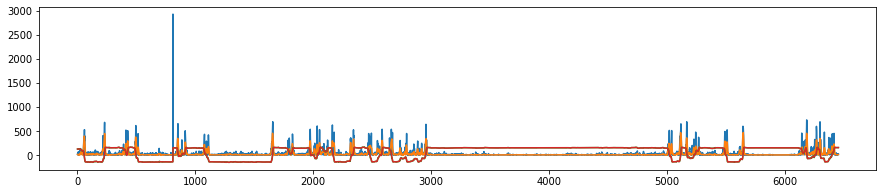

In [92]:
plt.figure(figsize=(15,3))
plt.plot(speed_linear*10)
plt.plot(speed*10)
plt.plot(pos_linear_sm)
plt.plot(pos_linear_for_spd)
# plt.xlim([3500,4000])

In [93]:
spd_thr = np.where(speed>v1)[0]
idx_end = np.where(np.diff(spd_thr)>1)[0]
idx_end = np.append(idx_end,len(spd_thr)-1)
idx_st = idx_end[:-1]+1
idx_st = np.insert(idx_st,0,0)
Idx = []

idx_st_thr = []
idx_end_thr = []
epocharray = []
for i in range(len(idx_st)):
    if np.where(speed[spd_thr[idx_st[i]:idx_end[i]]]>v2)[0].shape[0]>6: # speed>v1 for at least 0.5s*6=3s
        Idx.append(np.arange(spd_thr[idx_st[i]],spd_thr[idx_end[i]]))
        idx_st_thr.append(spd_thr[idx_st[i]])
        idx_end_thr.append(spd_thr[idx_end[i]])
        epocharray.append([time[idx_st_thr[-1]],time[idx_end_thr[-1]]])
idx_st_thr = np.array(idx_st_thr)
idx_end_thr = np.array(idx_end_thr)
Idx = np.concatenate(Idx)
pos_run = pos_linear[Idx]

In [94]:
Idx.shape

(982,)

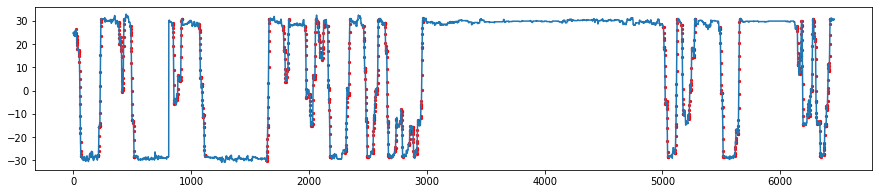

In [96]:
plt.figure(figsize=(15,3))
plt.plot(pos_linear/5)
plt.scatter(Idx,pos_run/5,color=[1,0,0],s=5)

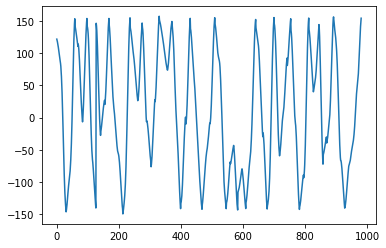

In [97]:
plt.plot(pos_linear_for_spd[Idx])

## run

In [98]:
maze_epoch = nel.EpochArray([time[0]-tbin/2,time[-1]+tbin/2])
maze_epoch

<EpochArray at 0x7f2aa55a6550: 1 epoch> of length 53:49 minutes

In [99]:
d = np.load('/home/kemerelab/Downloads/mazesEEG/RatS-Day5TwoNovel-2020-12-04_07-55-09_spikes.npy',allow_pickle=True)
st = nel.SpikeTrainArray(timestamps=d.item(0)['times'],support=maze_epoch) 

/home/kemerelab/nelpy/nelpy/core/_eventarray.py:443: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/kemerelab/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/kemerelab/nelpy/nelpy/core/_eventarray.py:504: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [100]:
time[[0,-1]],time.shape

(array([20766. , 23994.5]), (6458,))

In [101]:
np.min(np.concatenate(st.data)),np.max(np.concatenate(st.data))

(20765.754233333333, 23994.7491)

In [102]:
spikes = st.bin(ds=0.5)
spikes, spikes.bin_centers, spikes.data.shape

(<BinnedSpikeTrainArray at 0x7f2aa55a6a00: 109 ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109'] in 6,458 bins of width 500.0 milliseconds> for a total of 53:49 minutes,
 array([20766. , 20766.5, 20767. , ..., 23993.5, 23994. , 23994.5]),
 (109, 6458))

In [103]:
mazetime[[0,-1]],spikes.bin_centers[[0,-1]]

(array([20756.00817698, 24003.99278988]), array([20766. , 23994.5]))

In [104]:
spikes_run = spikes.data[:,Idx]
spikes_run.shape

(109, 982)

(982,)

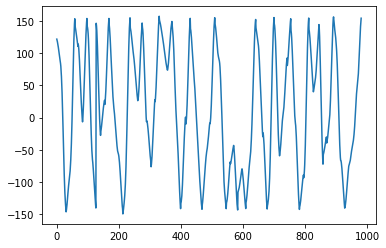

In [105]:
plt.plot(pos_linear_for_spd[Idx])
pos_linear_for_spd[Idx].shape

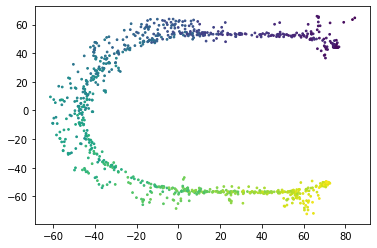

In [109]:
pos_linear_spk = pos_linear_for_spd[Idx]
pos_2d_spkfs = pos_origin[:,Idx]
plt.scatter(pos_2d_spkfs[0,:],pos_2d_spkfs[1,:],s=3,c=pos_linear_spk)

In [110]:
dic = {"pos_origin": pos_origin[:,Idx],"pos_linear": pos_linear_for_spd[Idx], "idx": Idx+1,"time": time[Idx], "spikes": spikes_run, "info":['pos savgol_filter width: 21','minimum running epoch length: 0.5s*6','time bin size: 500ms']}
dic["pos_origin"].shape, dic["pos_linear"].shape, dic["idx"].shape, dic["idx"].shape,dic["spikes"].shape

((2, 982), (982,), (982,), (982,), (109, 982))

In [111]:
name = period_names[maze_id]+'_run_v1_'+str(v1)+'_v2_'+str(v2)+'_500ms.mat'
name

'maze2_run_v1_3_v2_5_500ms.mat'

In [112]:
savemat(name,dic)

# Bin PBE data

In [ ]:
pbe = np.load('RatS-Day5TwoNovel-2020-12-04_07-55-09.pbe.npy',allow_pickle=True)
pbe.item(0)

In [ ]:
epochs = np.vstack((pbe.item(0)['events']['start'].values,pbe.item(0)['events']['end'].values))
pbe_bounds = nel.EpochArray(epochs.T)
pbe_bounds.data

In [ ]:
d = np.load('RatS-Day5TwoNovel-2020-12-04_07-55-09_spikes.npy',allow_pickle=True)
st = nel.SpikeTrainArray(timestamps=d.item(0)['times'],support=pbe_bounds)
st

In [ ]:
seg = st[period_bounds[0]]
seg.support

In [ ]:
for i in range(1,5):
    seg = st[period_bounds[i]]
    nel.save_pkl(period_names[i]+'.nel', seg)

In [4]:
d = np.load('/home/kemerelab/Downloads/mazesEEG/RatS-Day5TwoNovel-2020-12-04_07-55-09_spikes.npy',allow_pickle=True)
d.item()

{'times': [array([1.25833333e-01, 1.68066667e-01, 2.62366667e-01, ...,
         4.23058064e+04, 4.23058073e+04, 4.23058092e+04]),
  array([2.00300000e-01, 2.06566667e-01, 5.03733333e-01, ...,
         4.22813601e+04, 4.22844872e+04, 4.23004223e+04]),
  array([2.91300000e-01, 1.29706667e+00, 1.53516667e+00, ...,
         4.22985161e+04, 4.23021953e+04, 4.23042901e+04]),
  array([1.72250000e+00, 2.55270000e+00, 3.88660000e+00, ...,
         4.23054246e+04, 4.23054311e+04, 4.23054368e+04]),
  array([1.08366667e-01, 1.23966667e-01, 1.30500000e-01, ...,
         4.23055321e+04, 4.23055786e+04, 4.23057283e+04]),
  array([5.11870000e+00, 5.13906667e+00, 7.44833333e+00, ...,
         4.21445523e+04, 4.21655800e+04, 4.22317143e+04]),
  array([1.43633333e-01, 2.04433333e-01, 2.47733333e-01, ...,
         4.23055696e+04, 4.23055953e+04, 4.23056171e+04]),
  array([9.18100000e+00, 4.81868667e+01, 5.46816333e+01, ...,
         4.19935974e+04, 4.20284080e+04, 4.21895942e+04]),
  array([2.49455000e+01

In [5]:
FR = []
for i in d.item()['times']:
    FR.append(i.size)
FR

[280944,
 47282,
 33971,
 65953,
 649240,
 4577,
 875249,
 3581,
 24309,
 1108,
 16160,
 30528,
 561854,
 92998,
 60041,
 545898,
 47827,
 4232,
 42400,
 102596,
 5730,
 235222,
 647584,
 3568,
 375513,
 72480,
 252724,
 38671,
 4564,
 114706,
 171740,
 333972,
 337761,
 95934,
 5649,
 100055,
 39975,
 4060,
 182514,
 7058,
 7223,
 13817,
 17723,
 60174,
 69094,
 6623,
 111470,
 81424,
 9451,
 6860,
 7109,
 1091702,
 2824,
 16530,
 32168,
 71908,
 8903,
 52735,
 7369,
 52355,
 4791,
 48780,
 26458,
 20359,
 13488,
 23744,
 253369,
 954399,
 7086,
 92056,
 93614,
 118754,
 171735,
 49034,
 160623,
 18167,
 97258,
 26252,
 6376,
 8612,
 11139,
 755110,
 120064,
 87920,
 130226,
 359029,
 732353,
 8846,
 1191068,
 404152,
 108673,
 17371,
 122904,
 48256,
 76052,
 31701,
 123849,
 190273,
 6974,
 133214,
 134788,
 345297,
 376307,
 51688,
 32080,
 157942,
 52346,
 2883,
 63667]